In [ ]:
#######STEP 1 - Filter DIANA Database for qPCR, western blot and reporter assay data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np
import seaborn as sns

In [2]:
# Read files
file_path = 'DIANATarBase_allvalidations.tsv'

In [3]:
# Read the DIANA TSV file in chunks - large file, avoid failure
chunk_size = 100000  
unique_methods = set()

In [7]:
# Print the list of experimental methods for DIANA
try:
    for chunk in pd.read_csv(file_path, sep='\t', usecols=['experimental_method'], chunksize=chunk_size):
        unique_methods.update(chunk['experimental_method'].dropna().unique())
    
    # Convert set to sorted list
    unique_methods = sorted(unique_methods)
    print(f"Found {len(unique_methods)} unique experimental methods:")
    for method in unique_methods:
        print(method)

except FileNotFoundError:
    print("The specified file was not found.")
except pd.errors.EmptyDataError:
    print("The file is empty.")
except pd.errors.ParserError:
    print("There was an error parsing the file. Ensure it is a valid TSV format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Found 31 unique experimental methods:
2D-DIGE
3LIFE
AGO-IP
Biotin-Microarrays
Biotin-Seq
Biotin-qPCR
CLASH
Chimeric fragments
ELISA
Flow Cytometry
Genetic Testing
HITS-CLIP
IMPACT-Seq
Immunofluorescence
Immunohistochemistry
In Situ Hybridization
Luciferase Reporter Assay
Microarrays
Northern Blot
Other
PAR-CLIP
RIP-Seq
RNA-Seq
RPF-Seq
SILAC
TRAP
Western Blot
pSILAC
qCLASH
qPCR
sRNA-Seq


In [9]:
# Methods to filter
methods_to_keep = {'Western Blot', 'Luciferase Reporter Assay', 'qPCR'}

In [11]:
filtered_data = pd.DataFrame()

In [13]:
# Filter only required methods
for chunk in pd.read_csv(file_path, sep='\t', chunksize=chunk_size, low_memory=False):
    # Filter the chunk for the specified methods
    filtered_chunk = chunk[chunk['experimental_method'].isin(methods_to_keep)]
    filtered_data = pd.concat([filtered_data, filtered_chunk], ignore_index=True)

In [14]:
print(f"Filtered data contains {len(filtered_data)} rows with specified experimental methods.")

Filtered data contains 5578 rows with specified experimental methods.


In [17]:
# Save excel
save_option = input("Do you want to save the filtered data as an Excel file? (yes/no): ").strip().lower()

if save_option == 'yes':
    filtered_file_path = 'DIANATarbase_allstrongvalidations.xlsx'
    filtered_data.to_excel(filtered_file_path, index=False)
    print(f"Filtered data has been saved to '{filtered_file_path}'.")
else:
    print("Filtered data was not saved.")

Do you want to save the filtered data as an Excel file? (yes/no):  no


Filtered data was not saved.


In [ ]:
####PART2 - Database comparison

In [17]:
# Load miRTarBase Excel file
mirtarbase_file = 'miRTarBase_allstrongvalidations.xlsx' #renamed: miRTarBase_SE_WR.csv, and converted to xlsx
mirtarbase_df = pd.read_excel(mirtarbase_file)

In [19]:
#Filter miRTarBase for human miRNA (hsa)
mirtarbase_human = mirtarbase_df[mirtarbase_df['Species (miRNA)'] == 'hsa']

In [21]:
# Extract unique MTI for both databases
diana_unique = filtered_data[['mirna_name', 'gene_name']].drop_duplicates()
diana_unique['interaction'] = diana_unique['mirna_name'] + ':' + diana_unique['gene_name']
diana_unique_set = set(diana_unique['interaction'])

mirtarbase_human_unique = mirtarbase_human[['miRNA', 'Target Gene']].drop_duplicates()
mirtarbase_human_unique['interaction'] = mirtarbase_human_unique['miRNA'] + ':' + mirtarbase_human_unique['Target Gene']
mirtarbase_unique_set = set(mirtarbase_human_unique['interaction'])

In [23]:
print(f"Unique interactions in DIANA TarBase: {len(diana_unique_set)}")
print(f"Unique interactions in miRTarBase (human only): {len(mirtarbase_unique_set)}")

Unique interactions in DIANA TarBase: 2834
Unique interactions in miRTarBase (human only): 9496


In [30]:
save_unique = input("Do you want to save the filtered data as an Excel file? (yes/no): ").strip().lower()

# Save as Excel if the user confirms
if save_unique == 'yes':
  with pd.ExcelWriter('TarBase_miRTarBase_unique_interactions.xlsx') as writer:
      diana_unique.to_excel(writer, sheet_name='DIANA_Unique', index=False)
      mirtarbase_human_unique.to_excel(writer, sheet_name='miRTarBase_Human_Unique', index=False)

      print("Filtered unique interactions have been saved to 'TarBase_miRTarBase_unique_interactions.xlsx'.")
else:
    print("Unique interactions were not saved.")

Do you want to save the filtered data as an Excel file? (yes/no):  no


Unique interactions were not saved.


In [25]:
# Calculate adjusted Jaccard index normalized to the smaller database (DIANA TarBase)
intersection = diana_unique_set & mirtarbase_unique_set
min_size = min(len(diana_unique_set), len(mirtarbase_unique_set))
adjusted_jaccard_index = len(intersection) / min_size

In [27]:
print(f"Adjusted Jaccard Index (normalized to smaller database): {adjusted_jaccard_index:.4f}")

Adjusted Jaccard Index (normalized to smaller database): 0.6828


Do you want to save the venn as a PNG file? (yes/no):  yes


 Venn saved as 'venn_diagram_miRTarBase_vs_TarBase.png'


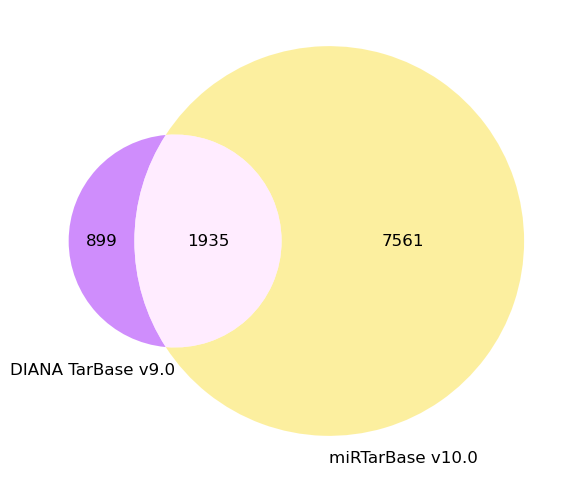

In [29]:
#Generate a Venn diagram
plt.figure(figsize=(8, 6))
venn = venn2(
    [diana_unique_set, mirtarbase_unique_set],
    ('DIANA TarBase v9.0', 'miRTarBase v10.0'),
    set_colors=('#bb5dfc', '#fce977'),
    alpha=0.7
)

total_unique = len(diana_unique_set | mirtarbase_unique_set)

only_diana = diana_unique_set - mirtarbase_unique_set
only_mirtar = mirtarbase_unique_set - diana_unique_set
intersection = diana_unique_set & mirtarbase_unique_set

venn.get_label_by_id('10').set_text(f"{len(only_diana)}")
venn.get_label_by_id('01').set_text(f"{len(only_mirtar)}")
venn.get_label_by_id('11').set_text(f"{len(intersection)}")

for label_id in ('10', '01', '11'):
    label = venn.get_label_by_id(label_id)
    if label:
        label.set_fontsize(12)

save_venn = input("Do you want to save the venn as a PNG file? (yes/no): ").strip().lower()

if save_venn == 'yes':
    venn_file_path = 'venn_diagram_miRTarBase_vs_TarBase.png'
    plt.savefig(venn_file_path, dpi=300, bbox_inches='tight')
    print(f" Venn saved as '{venn_file_path}'")

plt.show()

In [31]:
# Summary
print(f"DIANA TarBase Unique Interactions: {len(diana_unique_set)}")
print(f"miRTarBase Unique Interactions (human only): {len(mirtarbase_unique_set)}")
print(f"Common Interactions: {len(intersection)}")
print(f"Adjusted Jaccard Index: {adjusted_jaccard_index:.4f}")

DIANA TarBase Unique Interactions: 2834
miRTarBase Unique Interactions (human only): 9496
Common Interactions: 1935
Adjusted Jaccard Index: 0.6828


In [2]:
#PART 3: Find Top 20 miRNAs with Most Unique Interactions

In [71]:
# Load the existing Excel file with unique interactions
excel_file = 'TarBase_miRTarBase_unique_interactions.xlsx'

In [73]:
diana_unique_df = pd.read_excel(excel_file, sheet_name='DIANA_Unique')
mirtarbase_unique_df = pd.read_excel(excel_file, sheet_name='miRTarBase_Human_Unique')

In [75]:
# Prepare sets of unique interactions for each miRNA across both databases
diana_unique_df['interaction'] = diana_unique_df['mirna_name'] + ':' + diana_unique_df['gene_name']
mirtarbase_unique_df['interaction'] = mirtarbase_unique_df['miRNA'] + ':' + mirtarbase_unique_df['Target Gene']

In [77]:
diana_interactions = diana_unique_df.groupby('mirna_name')['interaction'].apply(set)
mirtarbase_interactions = mirtarbase_unique_df.groupby('miRNA')['interaction'].apply(set)

In [79]:
combined_interactions = {}

for mirna, interactions in diana_interactions.items():
    combined_interactions[mirna] = interactions.copy()

for mirna, interactions in mirtarbase_interactions.items():
    if mirna in combined_interactions:
        combined_interactions[mirna].update(interactions)
    else:
        combined_interactions[mirna] = interactions.copy()

In [81]:
# Calculate the number of unique interactions per miRNA
miRNA_interaction_counts = {mirna: len(interactions) for mirna, interactions in combined_interactions.items()}

In [83]:
top_20_mirnas = sorted(miRNA_interaction_counts.items(), key=lambda x: x[1], reverse=True)[:20]

In [85]:
# Top 20 miRNAs with most unique interactions
print("Top 20 miRNAs with the most unique interactions:")
for mirna, count in top_20_mirnas:
    print(f"{mirna}: {count} unique interactions")

Top 20 miRNAs with the most unique interactions:
hsa-miR-155-5p: 247 unique interactions
hsa-miR-145-5p: 169 unique interactions
hsa-miR-21-5p: 163 unique interactions
hsa-miR-34a-5p: 137 unique interactions
hsa-miR-124-3p: 135 unique interactions
hsa-miR-125b-5p: 121 unique interactions
hsa-miR-29b-3p: 114 unique interactions
hsa-miR-200c-3p: 108 unique interactions
hsa-miR-29a-3p: 106 unique interactions
hsa-miR-24-3p: 102 unique interactions
hsa-miR-17-5p: 99 unique interactions
hsa-miR-26a-5p: 94 unique interactions
hsa-miR-27a-3p: 91 unique interactions
hsa-miR-1-3p: 88 unique interactions
hsa-miR-221-3p: 87 unique interactions
hsa-miR-204-5p: 81 unique interactions
hsa-miR-181a-5p: 80 unique interactions
hsa-miR-122-5p: 79 unique interactions
hsa-miR-20a-5p: 78 unique interactions
hsa-miR-200b-3p: 77 unique interactions


In [78]:
save_top_20 = input("Save the top 20 miRNAs with unique interactions as an Excel file? (yes/no): ").strip().lower()

if save_top_20 == 'yes':
    top_20_df = pd.DataFrame(top_20_mirnas, columns=['miRNA', 'Unique Interaction Count'])

    top_20_file = 'Top_20_miRNAs_with_Unique_Interactions_Validated.xlsx'
    with pd.ExcelWriter(top_20_file) as writer:
        top_20_df.to_excel(writer, sheet_name='Top_20_miRNAs', index=False)
    
    print(f"Results have been saved to '{top_20_file}'.")
else:
    print("Results were not saved.")

Do you want to save the top 20 miRNAs with unique interactions as an Excel file? (yes/no):  yes


Results have been saved to 'Top_20_miRNAs_with_Unique_Interactions_Validated.xlsx'.


In [ ]:
#PART 4: Histogram of unique interactions

In [55]:
# Standardize column names for merging
diana_unique_df = diana_unique_df.rename(columns={'mirna_name': 'miRNA', 'gene_name': 'Target_Gene'})
mirtarbase_unique_df = mirtarbase_unique_df.rename(columns={'miRNA': 'miRNA', 'Target Gene': 'Target_Gene'})

In [57]:
common_mirnas = set(diana_unique_df['miRNA']).intersection(set(mirtarbase_unique_df['miRNA']))

In [59]:
diana_unique_df = diana_unique_df[diana_unique_df['miRNA'].isin(common_mirnas)]
mirtarbase_unique_df = mirtarbase_unique_df[mirtarbase_df['miRNA'].isin(common_mirnas)]

In [61]:
combined_df = pd.concat([diana_unique_df, mirtarbase_unique_df], ignore_index=True)

In [63]:
# Remove duplicate MTIs (if present in both databases, count only once)
combined_df = combined_df.drop_duplicates(subset=['miRNA', 'Target_Gene'])

In [65]:
# Count unique validations per miRNA
mirna_validation_counts = combined_df.groupby('miRNA')['Target_Gene'].nunique().reset_index()
mirna_validation_counts.columns = ['miRNA', 'Unique_Validations']

Do you want to save the histogram as a PNG file? (yes/no):  yes


✅ Histogram saved as 'miRNA_frequency_histogram.png'


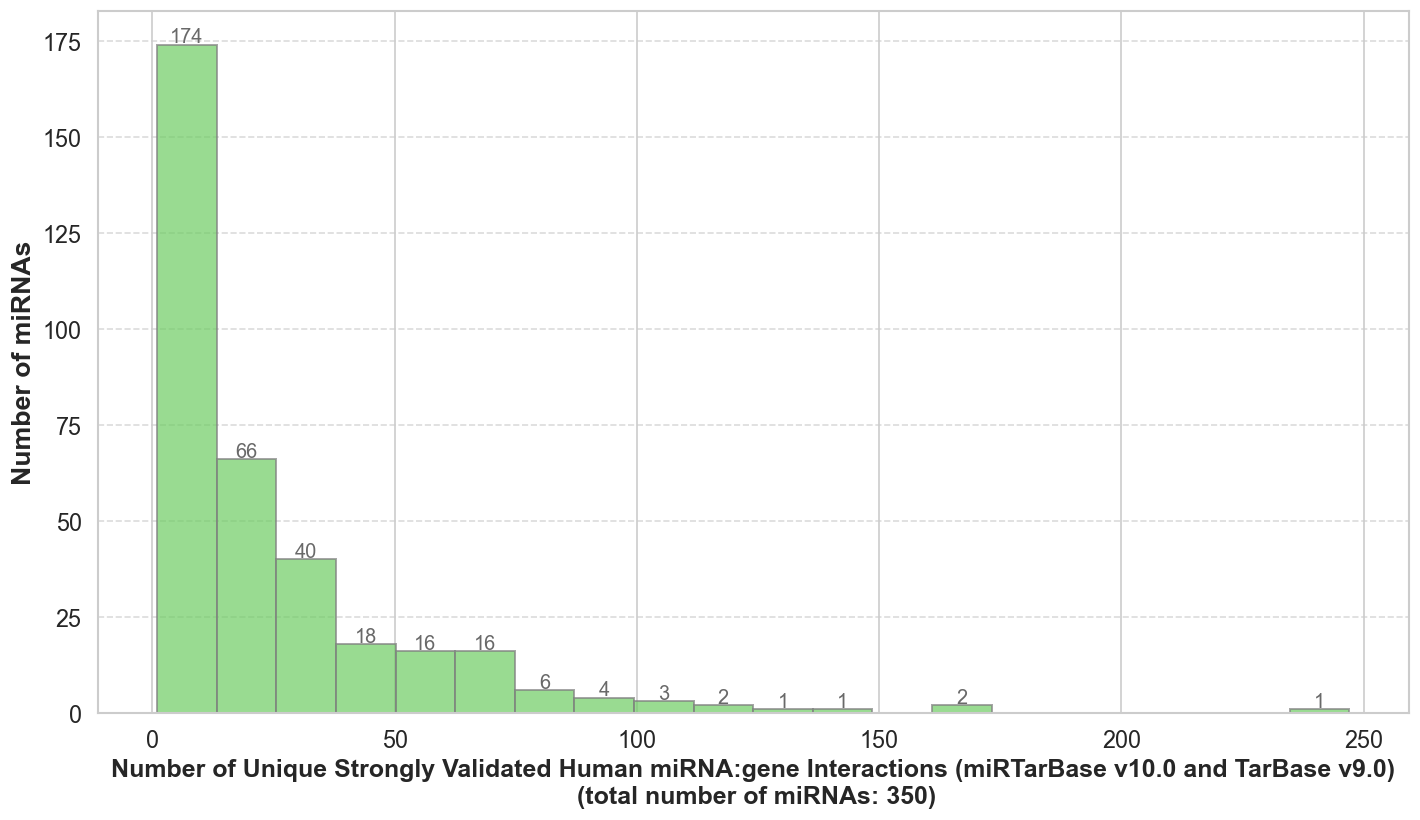

In [121]:
# Histogram 
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 7), dpi=120)

n, bins, patches = ax.hist(
    mirna_validation_counts['Unique_Validations'],
    bins=20,
    edgecolor='grey',
    alpha=0.7,
    color='#6ecc63',
    linewidth=1.2
)

ax.set_xlabel(
    'Number of Unique Strongly Validated Human miRNA:gene Interactions (miRTarBase v10.0 and TarBase v9.0)\n (total number of miRNAs: 350)',
    fontsize=15, fontweight="bold"
)
ax.set_ylabel('Number of miRNAs', fontsize=16, fontweight="bold")

ax.tick_params(axis='both', which='major', labelsize=14)

for i in range(len(n)):
    if n[i] > 0:
        ax.text(
            bins[i] + (bins[1] - bins[0]) / 2, n[i] + 0.5, str(int(n[i])),
            fontsize=12, ha='center', color='dimgray'
        )

ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

save_histogram = input("Do you want to save the histogram as a PNG file? (yes/no): ").strip().lower()
if save_histogram == 'yes':
    filename = "miRNA_frequency_histogram.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Histogram saved as '{filename}'")

plt.show()

In [ ]:
#PART5: Top 5 miRNA - Stacked bar chart - DIANA unique, miRTarBase Unique, Both

In [87]:
top_mirnas = [mirna for mirna, _ in top_20_mirnas[:5]]  # Top 5 for chart
diana_only_counts = []
mirtarbase_only_counts = []
both_counts = []
total_counts = []

In [89]:
for mirna in top_mirnas:
    diana_set = diana_interactions.get(mirna, set())
    mirtarbase_set = mirtarbase_interactions.get(mirna, set())
    
    common = diana_set & mirtarbase_set
    diana_only = diana_set - common
    mirtarbase_only = mirtarbase_set - common
    
    diana_only_counts.append(len(diana_only))
    mirtarbase_only_counts.append(len(mirtarbase_only))
    both_counts.append(len(common))
    total_counts.append(len(diana_only) + len(mirtarbase_only) + len(common))

In [91]:
diana_array = np.array(diana_only_counts)
mirtarbase_array = np.array(mirtarbase_only_counts)
both_array = np.array(both_counts)

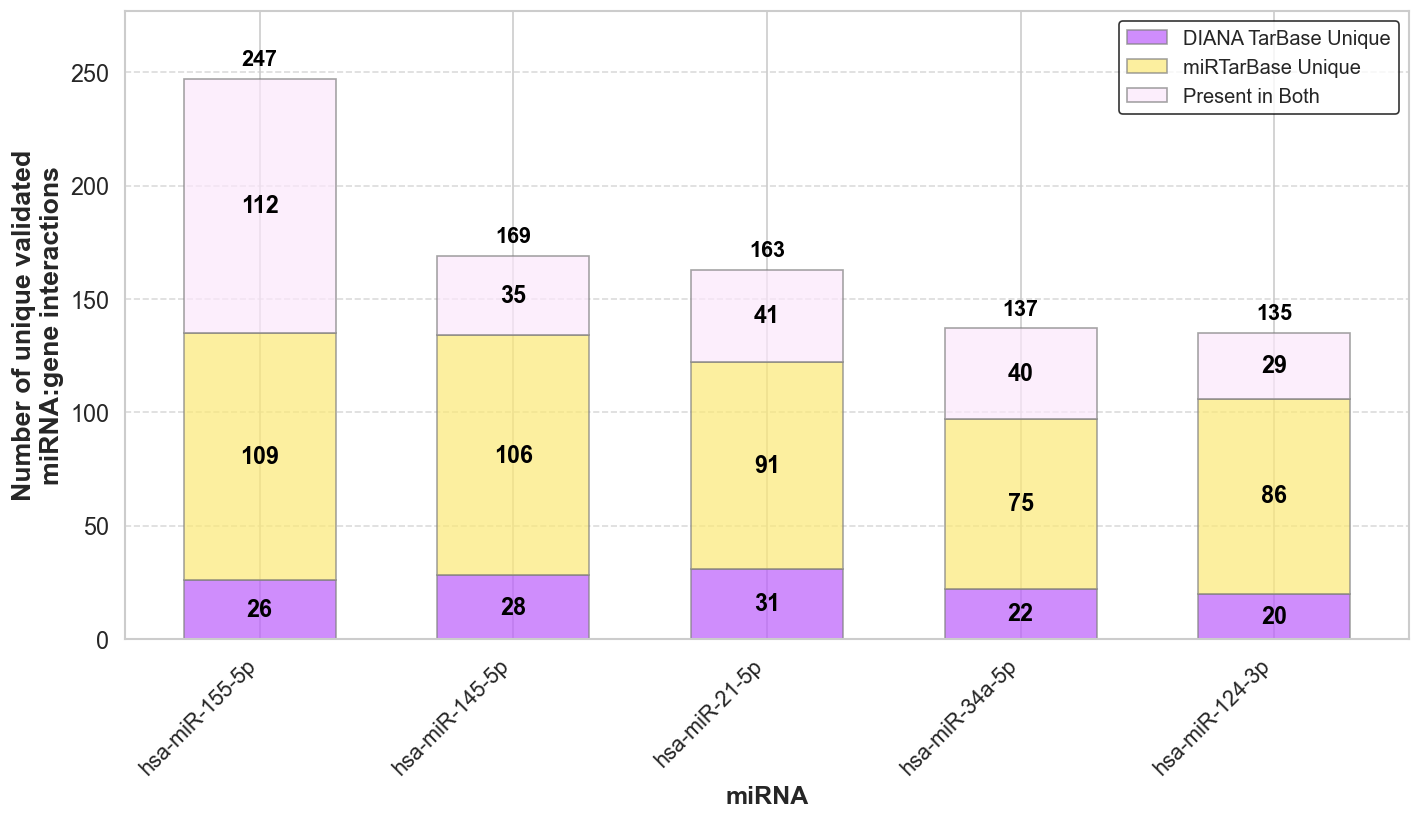

In [93]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 7), dpi=120)
bar_width = 0.6

colors = {
    "DIANA TarBase Unique": "#bb5dfc",
    "miRTarBase Unique": "#fce977",
    "Present in Both": "#fbe7fb"
}

p1 = ax.bar(top_mirnas, diana_array, bar_width,
            label="DIANA TarBase Unique",
            color=colors["DIANA TarBase Unique"],
            edgecolor='grey', linewidth=1, alpha=0.7)

p2 = ax.bar(top_mirnas, mirtarbase_array, bar_width,
            bottom=diana_array,
            label="miRTarBase Unique",
            color=colors["miRTarBase Unique"],
            edgecolor='grey', linewidth=1, alpha=0.7)

p3 = ax.bar(top_mirnas, both_array, bar_width,
            bottom=diana_array + mirtarbase_array,
            label="Present in Both",
            color=colors["Present in Both"],
            edgecolor='grey', linewidth=1, alpha=0.7)

ax.set_ylim(0, max(total_counts) + 30)
ax.set_xlabel("miRNA", fontsize=15, fontweight="bold")
ax.set_ylabel("Number of unique validated\nmiRNA:gene interactions", fontsize=16, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=13)
ax.tick_params(axis='y', labelsize=14)
ax.grid(axis="y", linestyle="--", alpha=0.7)

for bars in [p1, p2, p3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,
                    str(int(height)), ha="center", va="center", fontsize=14, color='black', fontweight="bold")

for i, total in enumerate(total_counts):
    ax.text(i, total + 6, str(total), ha="center", fontsize=13, fontweight="bold", color="black")

ax.legend(loc="upper right", fontsize=12, frameon=True, facecolor='white', edgecolor='black')
plt.tight_layout()

save_chart = input("Do you want to save the chart as a PNG file? (yes/no): ").strip().lower()
if save_chart == "yes":
    filename = "miRNA_Validations_StackedBar.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"✅ Chart saved as '{filename}'")

plt.show()